# Feature selection

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn import decomposition
import pickle

We use tree-based feature selection and PCA for dimensionality reduction of our dataset

In [125]:
df = pd.read_csv('./data/new_train.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# Find categorical variables
numerical = set(df.mean().index)
categorical = list(set(df.columns) - numerical) 

# Convert into categorical
for column in categorical:
    df[column] = df[column].astype('category')

df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,SalePrice,Month,DJREI,Fannie,LaborForce,UnemplRate,Corn
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,2008,WD,Normal,208500,200802,244.57,5.534,49426.0,3.0,3.923512
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,2007,WD,Normal,181500,200705,334.04,6.131,47518.0,2.6,3.287290
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,2008,WD,Normal,223500,200809,241.88,6.208,49516.0,3.0,5.329546
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,2006,WD,Abnorml,140000,200602,275.15,6.123,47959.0,2.9,2.139554
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,2008,WD,Normal,250000,200812,145.63,5.140,49657.0,3.7,5.309256


## Tree-based feature selection

We use a decision tree regressor model to identify features with the most importance for the model.

In [139]:

data = df.copy()

# Create sets
X = data.copy().drop('SalePrice', axis=1)
y = data.copy()['SalePrice']

# Create dummies
one_hot_data = pd.get_dummies(X[categorical],drop_first=True)

#Drop categorical
X = X.drop(categorical, axis=1)

# Merge with one hot
X = X.join(one_hot_data)

We perform cross-validation to find optimal pruning parameters.

In [187]:
# Create placeholders for the results
min_split = []
scores = []
min_leaf = []

# Set optimization parameters
m_smpl = np.linspace(start=10, stop=100,num=91, dtype='int')
m_lf = np.linspace(2, 7, num=6, dtype='int')

# Run optimization
for smpl in m_smpl:
    for lf in m_lf:
        tree = DecisionTreeRegressor(min_samples_split=smpl, min_samples_leaf=lf, random_state=0)
        cv = cross_val_score(tree,X, y, cv = 10)
        score = np.mean(cv)
        min_split = min_split + [smpl]
        min_leaf = min_leaf + [lf]
        scores = scores + [score]


In [188]:
tmp_ = pd.DataFrame({'score':scores, 'smpl':min_split, 'leaf':min_leaf})

In [189]:
tmp_.sort_values('score', ascending=False).head(20)

,score,smpl,leaf
186,0.783492,41,2
234,0.783162,49,2
127,0.783131,31,3
198,0.782986,43,2
133,0.782888,32,3
181,0.782861,40,3
187,0.782838,41,3
258,0.782709,53,2
204,0.782556,44,2
139,0.782409,33,3


We use optimized parameters (min_amples_split=41 and min_samples_leaf=2) to build the final model.

In [191]:
regression_tree = DecisionTreeRegressor(
 min_samples_split=41, min_samples_leaf=2,
  random_state=0)

regression_tree.fit(X,y)
regression_tree.score(X,y)


0.8869258823708526

In [193]:
importance = pd.DataFrame({'features':X.columns, 'imp':regression_tree.feature_importances_}).\
                        sort_values('imp',ascending=False)

importance_top20 = importance.iloc[:20,]

<BarContainer object of 20 artists>

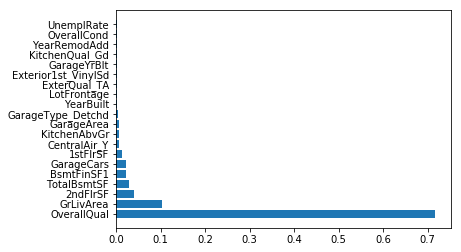

In [194]:
plt.barh(importance_top20.features, importance_top20.imp)

List factors with positive importance

In [197]:
feature_list_dt = list(importance.loc[importance.imp>0,'features'])

In [198]:
# Save features
pickle.dump(obj=feature_list_dt, file=open('./tmp/feaure_list_dt.list','wb'))

## LASSO feature selection

We perform LASSO linear regularization to see what features stay in the set.

In [203]:
# For feature selection we normalize data
data = df.copy()
data[list(numerical)] = normalize(data[list(numerical)]) #normalize

X = data.copy().drop('SalePrice', axis=1)
y = data.copy()['SalePrice']

one_hot_data = pd.get_dummies(df[categorical],drop_first=True)

#Drop categorical
X = X.drop(categorical, axis=1)

# Merge with one hot
X = X.join(one_hot_data)

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
coef = pd.Series(model_lasso.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 39 variables and eliminated the other 226 variables


In [204]:
pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)]).sort_values(ascending = False)

CentralAir_Y            0.025779
BsmtQual_Gd             0.011365
KitchenQual_Gd          0.010045
GarageType_Attchd       0.009105
GarageCond_TA           0.007961
SaleCondition_Normal    0.004926
Foundation_PConc        0.004862
Electrical_SBrkr        0.004332
MSZoning_RL             0.004292
GarageQual_TA           0.003769
GarageFinish_RFn        0.003635
ExterQual_Gd            0.003403
PavedDrive_Y            0.002924
Neighborhood_Crawfor    0.002128
MasVnrType_BrkFace      0.001723
Neighborhood_NWAmes     0.001330
BldgType_Duplex         0.000959
FireplaceQu_Gd          0.000916
Neighborhood_Somerst    0.000782
HouseStyle_2Story       0.000738
Neighborhood_ClearCr    0.000000
Neighborhood_BrkSide   -0.000000
LotConfig_Inside       -0.000061
BsmtExposure_Gd        -0.000103
GarageQual_No          -0.000605
MasVnrType_None        -0.000662
GarageFinish_No        -0.001295
Neighborhood_Edwards   -0.002391
GarageCond_No          -0.002590
HeatingQC_TA           -0.002766
ExterCond_

In [205]:
# Save features
feature_list_lasso = coef.index.values
pickle.dump(obj=feature_list_lasso, file=open('./tmp/feaure_list_lasso.list','wb'))



## PCA

We perform principal component analysis.

In [208]:
# For feature selection we normalize data
data = df.copy()

X = data.copy().drop('SalePrice', axis=1)
y = data.copy()['SalePrice']

one_hot_data = pd.get_dummies(df[categorical],drop_first=True)

#Drop categorical
X = X.drop(categorical, axis=1)

# Merge with one hot
X = X.join(one_hot_data)


pca = decomposition.PCA(n_components=X.shape[1])
pca.fit(X)
transformed = pca.transform(X)

explained_variance = np.var(transformed, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Find how may components explain >95% of variance
expl = np.cumsum(explained_variance_ratio)
len(expl[expl<=0.95])

expl

array([0.94316241, 0.98172199, 0.98660163, 0.98984162, 0.99250656,
       0.99481896, 0.99670676, 0.99838534, 0.99886323, 0.99915715,
       0.99940344, 0.99957873, 0.99971115, 0.9998142 , 0.99985341,
       0.99988527, 0.99991417, 0.99994062, 0.99995545, 0.99996972,
       0.99998151, 0.99998939, 0.99999506, 0.99999791, 0.99999981,
       0.99999987, 0.99999988, 0.99999989, 0.9999999 , 0.9999999 ,
       0.99999991, 0.99999991, 0.99999992, 0.99999992, 0.99999992,
       0.99999992, 0.99999993, 0.99999993, 0.99999993, 0.99999993,
       0.99999994, 0.99999994, 0.99999994, 0.99999994, 0.99999994,
       0.99999995, 0.99999995, 0.99999995, 0.99999995, 0.99999995,
       0.99999995, 0.99999996, 0.99999996, 0.99999996, 0.99999996,
       0.99999996, 0.99999996, 0.99999996, 0.99999996, 0.99999997,
       0.99999997, 0.99999997, 0.99999997, 0.99999997, 0.99999997,
       0.99999997, 0.99999997, 0.99999997, 0.99999997, 0.99999997,
       0.99999997, 0.99999998, 0.99999998, 0.99999998, 0.99999

In [123]:
# Save PCA
pickle.dump(pca, open('./tmp/pca', 'wb'))